# SASCA Tutorial

In the following, we will describe how to run a SASCA by using Stella. As an overview, this tutorial is composed in a few steps
* Generate a file that describes the implementation to attack.
* Generate traces 
* Compute SNR on all the variables to profile within the graph and build the model
* Generate the appropriate factor graph to run the attack
* Perform belief propagation on the graph to generate the attack

In this tutorial, we will mount a factor graph on a unprotected AES in a D&C fashion. We will do known and unknown plaintext attacks. For the tutorial to be short, all the function specific to this cases are stored in this directory but not in the notebook. (default path for simulated traces storage are also given there). 

## Step 1: Writing a graph file
In order to describe the factor graph, we rely on a .txt file which is parsed by Stella. The file is formatted in the following way for our D&C AES attack:

```
k0 #secret

#indeploop

p0 #public
x0 #profile
x0 = k0 ^ p0

#endindeploop

```
In this example, the variables (k0,p0,x0) can take 3 flags:
* secret: means that this is a variable that the adversary wants to known the distribution of. After the attack, he will get such a think.
* public: this is a public variable which is so known to the adversary. During the attack, that variable value has to be given to Stella.
* profile: is a variable that will be profiled by Stella (it will esptimate a pdf for it). During the attack, a probability table has to be given to Stella.

the indeploop tag must contain the encryption loop. The number of interation of the loop can be chosen later on from the Python interface.

In order to generate such a file, [gen_file.py](gen_file.py) contains such a function. We import it and generate the file.


In [1]:
from gen_file import write_file
file_name = "my_example.txt"

write_file(file_name=file_name,
          keyflag="secret",
          ptflag="profile",
          indepk=False,
          nbytes=16)  # max 16 for this example to match the traces simulation script

In order to visualize the factor graph, you can ask Stella to parse the file and generate the graph.

You can then change the flags in the file, the number of iteration and enjoy the vizualisation.

In [2]:
from stella.attacks.sasca.scripts.graph_parsing import build_graph_from_file,extract_flags
import matplotlib.pyplot as plt

public,profile,secret = extract_flags(file_name)
print("secrets: ", list(map(lambda x:x["label"],secret)))
print("public : ", list(map(lambda x:x["label"],profile)))
print("profile: ", list(map(lambda x:x["label"],public)))

secrets:  ['k0', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11', 'k12', 'k13', 'k14', 'k15']
public :  ['p0', 'x0', 'p1', 'x1', 'p2', 'x2', 'p3', 'x3', 'p4', 'x4', 'p5', 'x5', 'p6', 'x6', 'p7', 'x7', 'p8', 'x8', 'p9', 'x9', 'p10', 'x10', 'p11', 'x11', 'p12', 'x12', 'p13', 'x13', 'p14', 'x14', 'p15', 'x15']
profile:  []


Loop generation: 100%|██████████| 10/10 [00:00<00:00, 1468.39it/s]


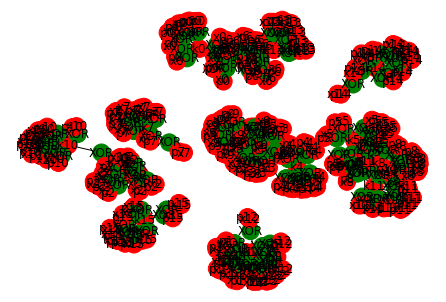

In [3]:
graph = build_graph_from_file(file_name,Nk=256,public=None,it=10)
graph.plot()

TODO: this graph generation can also be used to generate the labels if the secrets variables are also specified. This will be in another tutorial (which is not done yet).

## Step 2: Traces collection

In order to profile variables within the factor graph, one has to generate data. Stella is expecting to have the profiling traces in specific format.
* The traces are stored in the form [PREFIX_TRACES]\_[x].npy where x is an index. The traces are stored alone in a npy file for efficiency reasons. The traces are expected to be in int16 type (i.e. picoscope output).
* The correspond labels to the traces are in [PREFIX_LABELS]\_[x].npz. This file contains a list of directionary. Each dictionary contain filed 'label' of a variable to profile. It contains also 'val' which is the value of the variable to profile. 

Next, we generate the traces according to the settings from [sasca_flow_settings.py](sasca_flow_settings.py). Of courses, the traces can also be real traces taken from a scope.

In [4]:
from sasca_flow_settings import *
from sasca_flow import *

print("# Generate Traces")
gen_traces_sim(nfile_profile,ntraces,DIR_PROFILE_TRACES,tag)
gen_traces_attack_sim(nfile_attack,ntraces_attack,DIR_ATTACK_TRACES,tag)

print("# Generate Labels")
gen_labels(nfile_profile,DIR_PROFILE_TRACES,DIR_PROFILE_LABELS,tag)

example_labels = np.load(DIR_PROFILE_LABELS+tag+"_labels_0.npz",
                         allow_pickle=True)["labels"]

for label in example_labels[:4]: print("#",label)
    
print("#",PREFIX_PROFILE_LABELS)

# Generate Traces
# Generate Labels
# {'label': 'x0', 'val': array([ 85, 138,  20, ..., 104, 205,  27], dtype=uint8)}
# {'label': 'x1', 'val': array([195, 173, 208, ..., 131,  66,  30], dtype=uint8)}
# {'label': 'x2', 'val': array([  8,  47, 107, ..., 154,  33,  55], dtype=uint8)}
# {'label': 'x3', 'val': array([ 83,  10,  58, ...,  64, 176, 203], dtype=uint8)}
# /tmp/stella_ex/profile/labels/example_labels


## Step 3: Profiling variables

In order to profile variables, Stella works in three steps:
1. Compute SNR on the variables by taking as input the traces and the labels.
2. Extract the POIs based on the SNR computation.
3. Build the model for the variable based on traces at the POIs and labels.

We first parse the file to recover the flags to profile.

In [5]:
_,profile,_ = extract_flags(file_name)
profile = list(map(lambda l: l["label"],profile))
print("variables to profile :",profile)

variables to profile : ['p0', 'x0', 'p1', 'x1', 'p2', 'x2', 'p3', 'x3', 'p4', 'x4', 'p5', 'x5', 'p6', 'x6', 'p7', 'x7', 'p8', 'x8', 'p9', 'x9', 'p10', 'x10', 'p11', 'x11', 'p12', 'x12', 'p13', 'x13', 'p14', 'x14', 'p15', 'x15']


Stella implements the function write_snr() that the specified traces and labels. It then computes the SNR incrementially by loading the files one by one. The arguments specifies:
* Where to load the traces, the labels and where to store the results
* The number of files available to perform the attack
* The labels to be profiled
* The batch_size, which is the number of SNR computed in a single pass. -1 means that SNR on all labels is done in a single pass.
* The number of classes to compute the SNR on (typically 256 for 8-bit variables).

In [6]:
print("# 1. Computing the SNR on the files")
write_snr(PREFIX_PROFILE_TRACES,
                PREFIX_PROFILE_LABELS,
                FILE_SNR,
                nfile_profile,
                profile,
                verbose=True,
                batch_size=-1,
                Nc=Nk)

# 1. Computing the SNR on the files
x0 2.0287
x1 1.9955
x2 2.0359
x3 2.0107
x4 2.0192
x5 2.0131
x6 2.0192
x7 2.0272
x8 2.0139
x9 2.0206
x10 2.0350
x11 2.0090
x12 2.0352
x13 2.0069
x14 2.0063
x15 2.0167
p0 2.0187
p1 2.0042
p2 2.0320
p3 2.0126
p4 2.0143
p5 2.0112
p6 2.0204
p7 1.9823
p8 2.0110
p9 1.9972
p10 2.0087
p11 1.9907
p12 2.0133
p13 1.9966
p14 2.0059
p15 2.0087


In order to select the points of interest, the user is asked to provide a POI selection method that takes as input the snr and return the POIs. In the following example, it returns all 4 more leaking dimensions if the snr is larger the threshold for these variables. Else, it returns only the onces that are larger of the threshold.

The function write_poi will apply it to the SNR of all variables to profile and store the results.

In [17]:
def poi_selection(snr):
    ndim = 4
    return np.argsort(snr)[-ndim:] if len(np.where(snr>0.01)[0]) > ndim else np.where(snr>0.01)[0]

print("# 2. Getting POIs")
write_poi(FILE_SNR,FILE_POI,
            profile,
            poi_selection)
print("POIs :")
for x in np.load(FILE_POI,allow_pickle=True)["poi"][:4]: print(x)

# 2. Getting POIs
POIs :
{'poi': array([0]), 'label': 'x0'}
{'poi': array([1]), 'label': 'x1'}
{'poi': array([2]), 'label': 'x2'}
{'poi': array([3]), 'label': 'x3'}


A similar approach is taken to build the model. 

Below, we use a LDAClassifier from Stella to build the templates. It is a template applyed to the output of a LDA dimensionality reduction. Stella works with any profiling methods which is can be changed by the user. It should only return an object that implements predict_proba(traces).
As an example, you can uncomment some lines and use QDA from sklearn.

This step is typically the most expensive if the profiling. Of course, it depends on the method used.

In [9]:
from stella.estimator.classifiers import LDAClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

print("# 3. Building templates")
def model_fit(t,l,label):
    #m = QDA()
    #m.fit(t,l)
    m = LDAClassifier(t,l,solver="eigen",dim_projection=1)
    return m

build_model(PREFIX_PROFILE_TRACES,
                PREFIX_PROFILE_LABELS,
                FILE_POI,
                FILE_MODEL,
                nfile_profile,
                profile,
                model_fit,batch_size=-1)

# 3. Building templates
